## Imports

In [4]:
import json
import pandas as pd
import copy
import matplotlib as plt
import seaborn as sns
import glob
import fiftyone

import re
import os

## TACO dataset cleaning

In [2]:
# Load JSON

with open('../data/TACO/annotations.json') as f:
    data_taco = json.load(f)

In [3]:
# Pull dictionary of categories (60)

dict_taco = {}

for x in range(60):
    id = data_taco['categories'][x]['id']
    name = data_taco['categories'][x]['name']
    dict_taco[id] = name

In [6]:
# Instantiate new dictionary of 5 categories

final_categories = {
    0: 'Paper',
    1: 'Plastic',
    2: 'Glass',
    3: 'Metal',
    4: 'Organic',
    5: 'E-Waste',
    6: 'Non-recyclable'
}

In [5]:
# Create new mapping between categories

unique_cat_taco = list(dict_taco.values())
unique_cat_ids = set(key for key, val in dict_taco.items())

matching_cat_final = [
'Non-recyclable',
'E-Waste',
'Non-recyclable',
'Non-recyclable',
'Plastic',
'Plastic',
'Glass',
'Plastic',
'Metal',
'Glass',
'Non-recyclable',
'Metal',
'Metal',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Plastic',
'Non-recyclable',
'Non-recyclable',
'Plastic',
'Organic',
'Glass',
'Plastic',
'Metal',
'Plastic',
'Paper',
'Non-recyclable',
'Paper',
'Paper',
'Paper',
'Non-recyclable',
'Plastic',
'Plastic',
'Non-recyclable',
'Plastic',
'Plastic',
'Non-recyclable',
'Plastic',
'Plastic',
'Plastic',
'Plastic',
'Non-recyclable',
'Plastic',
'Plastic',
'Plastic',
'Metal',
'Non-recyclable',
'Metal',
'Non-recyclable',
'Non-recyclable',
'Plastic',
'Paper',
'Non-recyclable',
'!!! Remove !!!',
'Non-recyclable'
]



In [6]:
# Concatenate to Dataframe

unique_cat_taco = pd.DataFrame(unique_cat_taco, columns=['Taco category'])

matching_cat_final = pd.DataFrame(matching_cat_final, columns=['New category'])

matching_dict = pd.concat([unique_cat_taco, matching_cat_final], axis=1)


In [7]:
# Get list of IDs from original list

list_ids = []

for category in matching_dict['New category']:
    id = dict((new_val,new_k) for new_k,new_val in final_categories.items()).get(category)
    list_ids.append(id)
    
list_ids = pd.DataFrame(list_ids, columns=['New category IDs'])

# Concatenate to main dataframe

matching_dict = pd.concat([matching_dict,list_ids], axis=1)

In [8]:
# Remove the "Unlabeled litter"

matching_dict = matching_dict.drop(labels=58, axis=0)

# Convert floats to int32

matching_dict = matching_dict.astype({'New category IDs': int})


In [9]:
# Inspect final matching dictionary

matching_dict

,Taco category,New category,New category IDs
0,Aluminium foil,Non-recyclable,6
1,Battery,E-Waste,5
2,Aluminium blister pack,Non-recyclable,6
3,Carded blister pack,Non-recyclable,6
4,Other plastic bottle,Plastic,1
5,Clear plastic bottle,Plastic,1
6,Glass bottle,Glass,2
7,Plastic bottle cap,Plastic,1
8,Metal bottle cap,Metal,3
9,Broken glass,Glass,2


In [10]:
# Drop final matching dictionary to excel

pd.DataFrame(matching_dict).to_excel('../tables/taco_matching_dict.xlsx')

In [11]:
# Count number of images with category "Unlabeled litter" (category 58)

count_unlabeled = 0

for annotation in data_taco['annotations']:
    if annotation['category_id'] == 58:
        count_unlabeled += 1
        
count_unlabeled

517

We have a total of 517 annotations that are unlabeled out of 4784 total. We will have to drop ~11% of the annotations.

In [12]:
# Make a copy of JSON to keep original version

data_taco_new = copy.deepcopy(data_taco)

In [13]:
# Dropping the "Unlabeled litter"

for annotation in data_taco_new['annotations'][:]:
    if annotation['category_id'] == 58:
        data_taco_new['annotations'].remove(annotation)
    else:
        continue

In [14]:
len(data_taco_new['annotations'])

4267

In [15]:
# Overwrite the "categories" list

data_taco_new['categories'] = []

for index, category in final_categories.items():
    data_taco_new['categories'].append({
        "supercategory": category,
        "id": index,
        "name": category
    })

In [16]:
# Iterate over copy and change category in "annotations"

for annotation in data_taco_new['annotations']:
    annotation_cat_id = annotation['category_id']
    annotation['category_id'] = matching_dict[matching_dict.index == annotation_cat_id]['New category IDs'].item()


In [17]:
# Check images not being used anymore after removing annotations

list_image_ids = []

for x in  range(len(data_taco_new['annotations'])):
    list_image_ids.append(data_taco_new['annotations'][x]['image_id'])

list_image_ids = set(list_image_ids)

missing_images_ids = [ele for ele in range(max(list_image_ids)+1) if ele not in list_image_ids]

len(missing_images_ids)

19

A total of 19 images will be ignored out of 1.500 because they only have "unlabeled litters" as annotations.

In [18]:
# Drop final JSON file with new category IDs

with open("../data/TACO/annotations_new.json", "w") as outfile:
    json.dump(data_taco_new, outfile)

## Drinking Waste Classification cleaning

We will use the `fiftyone` library in order to convert from YOLO format to COCO format. 

We will use the COCO format as our source of truth before converting to TFRecord for feeding into the Tensorflow API.

In [19]:
# CLI commands to run to convert from YOLO (V.4) to COCO

fiftyone convert \
            --input-dir data/Drinking_Waste_Classification \
            --input-type fiftyone.types.YOLOv4Dataset \
            --output-dir data/Drinking_Waste_Classification_COCO \
            --output-type fiftyone.types.COCODetectionDataset

SyntaxError: invalid syntax (1593425222.py, line 3)

In [28]:
# Function to build the matching dictionary used to match categories between JSON files

def build_matching_dictionary(json_path,list_matching_cat):
    with open(json_path) as f:
        data_drinking_class = json.load(f)
    
    # Instantiate lists
    categories_drinking_class = []
    list_ids = []
    
    # Build lists

    for x in range(len(data_drinking_class['categories'])):
        categories_drinking_class.append(data_drinking_class['categories'][x]['name'])


    for category in list_matching_cat:
        list_ids.append([int(k) for k, v in final_categories.items() if v == category][0])


    # Concatenate into one central Dataframe

    matching_cat_drinking_class = pd.DataFrame(list_matching_cat, columns=['Matching category name'])
    categories_drinking_class = pd.DataFrame(categories_drinking_class, columns=['Original category name'])
    list_ids = pd.DataFrame(list_ids,columns=['Matching Category ID'])

    dict_drinking_class = pd.concat([categories_drinking_class, matching_cat_drinking_class, list_ids], axis=1)
    
    return dict_drinking_class

In [167]:
dict_drinking_class = build_matching_dictionary('../data/Drinking_Waste_Classification_COCO/labels.json',['Metal', 'Glass', 'Plastic', 'Plastic'])

dict_drinking_class

,Original category name,Matching category name,Matching Category ID
0,Aluminium Cans,Metal,3
1,Glass bottles,Glass,2
2,HDPE (plastic) Milk bottles,Plastic,1
3,PET (plastic) bottles,Plastic,1


In [22]:
# Function to change categories for each annotations with matching ones

def change_annotations(original_json_path,matching_dictionary):

    # Open JSON file and make copy

    with open(original_json_path) as f:
        original_json = json.load(f)

    new_json = copy.deepcopy(original_json)

    # Iterate over copy and change category in "annotations"

    for annotation in new_json['annotations']:
        annotation_cat_id = annotation['category_id']
        annotation['category_id'] = matching_dictionary[matching_dictionary.index == annotation_cat_id]['Matching Category ID'].item()

    return new_json

In [169]:
new_json = change_annotations("../data/Drinking_Waste_Classification_COCO/labels.json",dict_drinking_class)

{'id': 2501,
 'image_id': 2329,
 'category_id': 1,
 'bbox': [277.0, 389.00000000000006, 145.0, 228.0],
 'area': 33060.0,
 'iscrowd': 0}

In [23]:
# Function to overwrite the old categories with new ones

def overwrite_categories(json_file,final_categories):
    
    json_file['categories'] = []

    for index, category in final_categories.items():
        json_file['categories'].append({
            "supercategory": category,
            "id": index,
            "name": category
    })
        
    return json_file

In [172]:
final_json = overwrite_categories(new_json,final_categories)

In [24]:
# Function to change image names to reflect new directory ("batch_xx")

def change_image_names(json_file,batch_number):

    for img in json_file["images"]:
        img['file_name'] = "batch_" + str(batch_number) + "/" + img['file_name']
    
    return json_file

In [ ]:
final_json = change_image_names(final_json,16)

In [46]:
# Drop final JSON file with new category IDs

with open("../data/Drinking_Waste_Classification_COCO/labels_new.json", "w") as outfile:
    json.dump(final_json, outfile)

## Fruit Detection + Fruit Images for Object Detection cleaning

In [ ]:
# CLI command to convert Fruit_Detection to COCO

fiftyone convert \
            --input-dir data/Fruit_Detection \
            --input-type fiftyone.types.VOCDetectionDataset \
            --output-dir data/Fruit_Detection_COCO \
            --output-type fiftyone.types.COCODetectionDataset

In [ ]:
# Some images in Fruit_Images_for_Object_Detection have wrong labelling. 
# 👇 Script to remove images with width or height = 0

# 1. List the label files in folder
list_labels_path = glob.glob("../data/Fruit_Images_for_Object_Detection/labels/*")

# 2. Iterate over list with counter & delete files with width = 0

labels_deleted_count = 0

for path in list_labels_path:
    with open(path, 'r') as f:
        data = f.read()
    result = re.search('<width>(.*)</width>', data)
    width = int(result.group(1))
    
    if width == 0:
        data_path = path.replace('labels/', 'data/').replace('.xml', '.jpg')
        os.remove(path)
        os.remove(data_path)
        labels_deleted_count += 1

    else:
        continue

print("Total annotations deleted:" + labels_deleted_count)

We had to deleted 37 annotations out of 300 (~12% of the dataset) because it had no width & height information. Making it impossible to convert to COCO format.

In [ ]:
# CLI commands to convert Fruit_Images_for_Object_Detection to COCO

fiftyone convert \
            --input-dir data/Fruit_Images_for_Object_Detection \
            --input-type fiftyone.types.VOCDetectionDataset \
            --output-dir data/Fruit_Images_for_Object_Detection_COCO \
            --output-type fiftyone.types.COCODetectionDataset

In [182]:
# New JSON for Fruit_Detection

matching_dict = build_matching_dictionary('../data/Fruit_Detection_COCO/labels.json',['Organic','Organic','Organic','Organic'])

new_json = change_annotations('../data/Fruit_Detection_COCO/labels.json',matching_dict)

final_json = overwrite_categories(new_json,final_categories)

final_json = change_image_names(final_json,17)

# Drop final JSON file with new category IDs

with open("../data/Fruit_Detection_COCO/labels_new.json", "w") as outfile:
    json.dump(final_json, outfile)

In [183]:
# New JSON for Fruit_Images_for_Object_Detection

matching_dict = build_matching_dictionary('../data/Fruit_Images_for_Object_Detection_COCO/labels.json',['Organic','Organic','Organic'])

new_json = change_annotations('../data/Fruit_Images_for_Object_Detection_COCO/labels.json',matching_dict)

final_json = overwrite_categories(new_json,final_categories)

final_json = change_image_names(final_json,18)

# Drop final JSON file with new category IDs

with open("../data/Fruit_Images_for_Object_Detection_COCO/labels_new.json", "w") as outfile:
    json.dump(final_json, outfile)


## Mobile Images Dataset cleaning

In [ ]:
# Convert to COCO format

fiftyone convert \
            --input-dir data/Mobile_Images_Dataset \
            --input-type fiftyone.types.VOCDetectionDataset \
            --output-dir data/Mobile_Images_Dataset_COCO \
            --output-type fiftyone.types.COCODetectionDataset

In [191]:
# New JSON for Mobile_Images_Dataset

matching_dict = build_matching_dictionary('../data/Mobile_Images_Dataset_COCO/labels.json',['E-Waste'])

new_json = change_annotations('../data/Mobile_Images_Dataset_COCO/labels.json',matching_dict)

final_json = overwrite_categories(new_json,final_categories)

final_json = change_image_names(final_json,19)

# Drop final JSON file with new category IDs

with open("../data/Mobile_Images_Dataset_COCO/labels_new.json", "w") as outfile:
    json.dump(final_json, outfile)

## Garbage Classification cleaning (paper + cardboard)

In [195]:
# New JSON for Mobile_Images_Dataset

matching_dict = build_matching_dictionary('../data/Garbage_Classification/annotations_coco.json',['Paper', 'Paper'])

new_json = change_annotations('../data/Garbage_Classification/annotations_coco.json',matching_dict)

final_json = overwrite_categories(new_json,final_categories)

final_json = change_image_names(final_json,20)

# Drop final JSON file with new category IDs

with open("../data/Garbage_Classification/annotations_coco_new.json", "w") as outfile:
    json.dump(final_json, outfile)

## Open Images cleaning (for E-Waste)

We will pick the following classes from the 600 different classes available:
- Computer keyboard
- Computer monitor
- Computer mouse
- Tablet computer
- Laptop
- Camera
- Television
- Headphones
- Microwage oven
- Printer
- Light bulb

In [ ]:
dataset = fiftyone.zoo.load_zoo_dataset(
              "open-images-v6",
              split="validation",
              label_types=["detections"],
              classes=["Computer keyboard", "Computer monitor", "Computer mouse", "Tablet computer", "Headphones", "Laptop", "Camera", "Microwage oven", "Printer", "Television", "Light bulb"]
          )

In [ ]:
dataset = fiftyone.zoo.load_zoo_dataset(
              "open-images-v6",
              split="test",
              label_types=["detections"],
              classes=["Computer keyboard", "Computer monitor", "Computer mouse", "Tablet computer", "Headphones", "Laptop", "Camera", "Microwage oven", "Printer", "Television", "Light bulb"]
          )

In [29]:
# New JSON for Open_Images dataset (E-Waste)

matching_dict = build_matching_dictionary('../data/Open_Images_E-Waste/annotations_coco.json',['E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste', 'E-Waste'])

new_json = change_annotations('../data/Open_Images_E-Waste/annotations_coco.json',matching_dict)

final_json = overwrite_categories(new_json,final_categories)

final_json = change_image_names(final_json,21)

# Drop final JSON file with new category IDs

with open("../data/Open_Images_E-Waste/annotations_coco_new.json", "w") as outfile:
    json.dump(final_json, outfile)

## Stitching together final dataset

In [148]:
# Migrate pics to new folders (CLI) for all datasets

# TACO
⬛️ cp -a data/TACO/ data/Final_Dataset

⬛️ rm data/Final_Dataset/all_image_urls.csv data/Final_Dataset/annotations_new.json data/Final_Dataset/annotations_unofficial.json data/Final_Dataset/annotations.json

# Drinking_Waste_Classification
⬛️ mkdir data/Final_Dataset/batch_16

⬛️ cp -a data/Drinking_Waste_Classification_COCO/data/ data/Final_Dataset/batch_16

# Fruit_Detection
⬛️ mkdir data/Final_Dataset/batch_17

⬛️ cp -a data/Fruit_Detection_COCO/data/ data/Final_Dataset/batch_17

# Fruit_Images_for_Object_Detection
⬛️ mkdir data/Final_Dataset/batch_18

⬛️ cp -a data/Fruit_Images_for_Object_Detection/data/ data/Final_Dataset/batch_18

# Mobile_Images_Dataset

⬛️ mkdir data/Final_Dataset/batch_19

⬛️ cp -a data/Mobile_Images_Dataset_COCO/data/ data/Final_Dataset/batch_19

# Garbage_Classification_Paper

⬛️ mkdir data/Final_Dataset/batch_20

⬛️ cp -a data/Garbage_Classification/data/ data/Final_Dataset/batch_20

# Open_Images_E-Waste

⬛️ mkdir data/Final_Dataset/batch_21

⬛️ cp -a data/Open_Images_E-Waste/data/ data/Final_Dataset/batch_21

SyntaxError: invalid syntax (2255174747.py, line 4)

In [184]:
# Merge the two COCO files
# We use a custom script available in the 'repos' folder called "Merge_COCO_FIES"

# Command 👇

⬛️ python merge.py '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/TACO/annotations_new.json' \
    '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Drinking_Waste_Classification_COCO/labels_new.json' \
        '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V1.json'

SyntaxError: invalid character in identifier (2116763647.py, line 6)

In [ ]:

# Final merging of COCO json files


# Fruit Detection (for organic)

⬛️ python merge.py '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V1.json' \
    '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Fruit_Detection_COCO/labels_new.json' \
        '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V2.json'

# Fruit Images for Object Detection (for organic)

⬛️ python merge.py '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V2.json' \
    '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Fruit_Images_for_Object_Detection_COCO/labels_new.json' \
        '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V3.json'


# Mobile Images Dataset (for e-waste)

⬛️ python merge.py '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V3.json' \
    '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Mobile_Images_Dataset_COCO/labels_new.json' \
        '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V4.json'


# Adding Garbage Classification (for paper + cardboard)

⬛️ python merge.py '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V4.json' \
    '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Garbage_Classification/annotations_coco_new.json' \
        '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V5.json'

# Adding Open Images (for E-Waste)

⬛️ python merge.py '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V5.json' \
    '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Open_Images_E-Waste/annotations_coco_new.json' \
        '/Users/julienberthomier/code/AmElmo/Main_Projects/Trash Detector (Wall-E)/data/Final_Dataset/final_annotations_coco_V6.json'

## Visualize final data histogram

In [2]:
# Create main functions for class distribution

def draw_class_distribution(file_path):
    with open(file_path) as f:
        final_annotations = json.load(f)

    list_cat_ids = []
    list_categories = []

    for annotation in final_annotations['annotations']:
        list_cat_ids.append(annotation['category_id'])

    for annot in list_cat_ids:
        list_categories.append(final_categories[annot])

    list_cat_ids = pd.DataFrame(list_cat_ids, columns=['List IDs'])
    list_categories = pd.DataFrame(list_categories, columns=['List categories'])

    hist_categories = pd.concat([list_cat_ids,list_categories], axis=1)
    
    return sns.histplot(data=hist_categories, y='List categories')

def build_table_distribution(file_path):
    with open(file_path) as f:
        final_annotations = json.load(f)

    list_cat_ids = []
    list_categories = []

    for annotation in final_annotations['annotations']:
        list_cat_ids.append(annotation['category_id'])

    for annot in list_cat_ids:
        list_categories.append(final_categories[annot])

    list_cat_ids = pd.DataFrame(list_cat_ids, columns=['List IDs'])
    list_categories = pd.DataFrame(list_categories, columns=['List categories'])

    hist_categories = pd.concat([list_cat_ids,list_categories], axis=1)
    
    return hist_categories['List categories'].value_counts()

def build_table_distribution_normalize(file_path):
    with open(file_path) as f:
        final_annotations = json.load(f)

    list_cat_ids = []
    list_categories = []

    for annotation in final_annotations['annotations']:
        list_cat_ids.append(annotation['category_id'])

    for annot in list_cat_ids:
        list_categories.append(final_categories[annot])

    list_cat_ids = pd.DataFrame(list_cat_ids, columns=['List IDs'])
    list_categories = pd.DataFrame(list_categories, columns=['List categories'])

    hist_categories = pd.concat([list_cat_ids,list_categories], axis=1)
    
    return hist_categories['List categories'].value_counts(normalize=True)*100

    

### TACO dataset

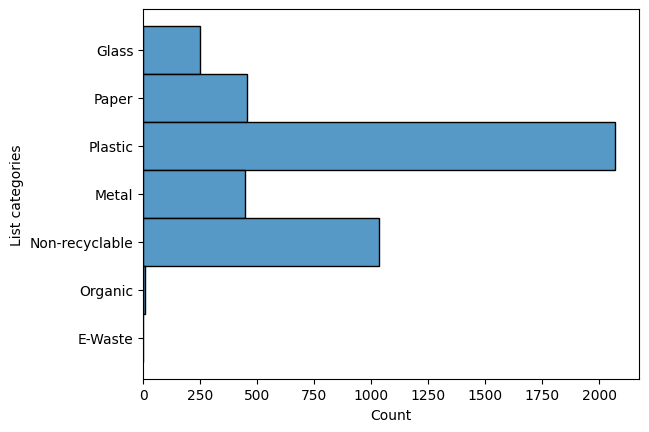

In [61]:
draw_class_distribution('../data/TACO/annotations_new.json');

In [84]:
build_table_distribution('../data/TACO/annotations_new.json')

Plastic           2071
Non-recyclable    1035
Paper              455
Metal              448
Glass              248
Organic              8
E-Waste              2
Name: List categories, dtype: int64

In [91]:
build_table_distribution_normalize('../data/TACO/annotations_new.json')

Plastic           48.535271
Non-recyclable    24.255918
Paper             10.663229
Metal             10.499180
Glass              5.812046
Organic            0.187485
E-Waste            0.046871
Name: List categories, dtype: float64

We have a clear class inbalance with the following classes having very few annotations:
- Organic (only 8)
- E-Waste (only 2)

And the following classes with few annotations (< 1000):
- Glass
- Metal
- Paper


### Drinking Waste Classification

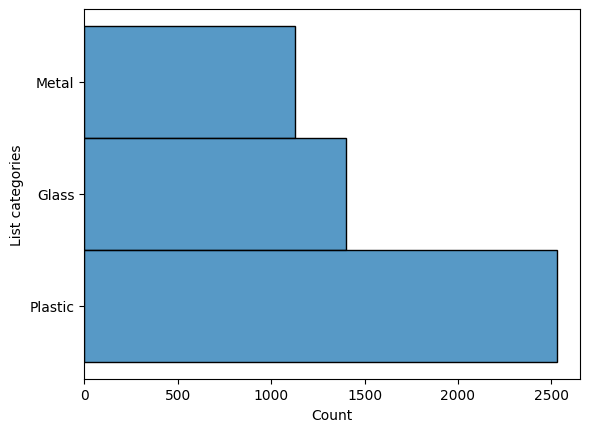

In [69]:
draw_class_distribution('../data/Drinking_Waste_Classification_COCO/labels_new.json')

In [73]:
build_table_distribution('../data/Drinking_Waste_Classification_COCO/labels_new.json')

Plastic    2528
Glass      1402
Metal      1128
Name: List categories, dtype: int64

In [92]:
build_table_distribution_normalize('../data/Drinking_Waste_Classification_COCO/labels_new.json')

Plastic    49.980229
Glass      27.718466
Metal      22.301305
Name: List categories, dtype: float64

This dataset will help us improve the class imbalance of the TACO dataset on the following categories:
- plastic
- glass
- metal


We still need to get datasets for organic & e-waste categories. 

### TACO + Drinking Waste Classification

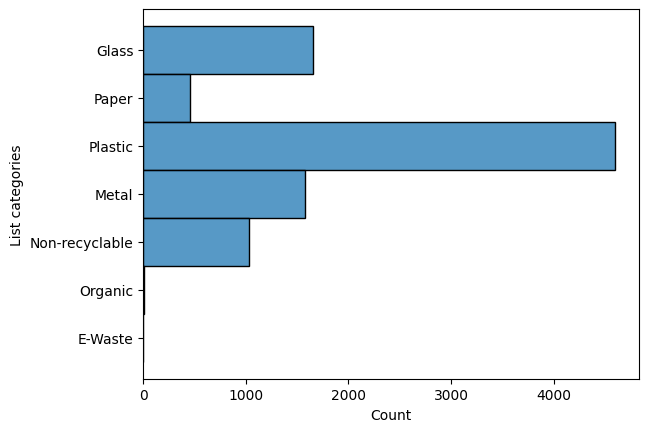

In [98]:
draw_class_distribution('../data/Final_Dataset/final_annotations_coco_V1.json');

In [100]:
build_table_distribution('../data/Final_Dataset/final_annotations_coco_v1.json')

Plastic           4599
Glass             1650
Metal             1576
Non-recyclable    1035
Paper              455
Organic              8
E-Waste              2
Name: List categories, dtype: int64

In [99]:
build_table_distribution_normalize('../data/Final_Dataset/final_annotations_coco_v1.json')

Plastic           49.319035
Glass             17.694370
Metal             16.900804
Non-recyclable    11.099196
Paper              4.879357
Organic            0.085791
E-Waste            0.021448
Name: List categories, dtype: float64

We have a large class imbalance for the following categories:
  - Paper (~4.9% of the dataset)
  - Organic (~0.09% of the dataset)
  - E-Waste (~0.02% of the dataset)

We can consider that we have enough annotations for plastic, glass, metal and non-recyclable items.

### Final Dataset Distribution

<AxesSubplot:xlabel='Count', ylabel='List categories'>

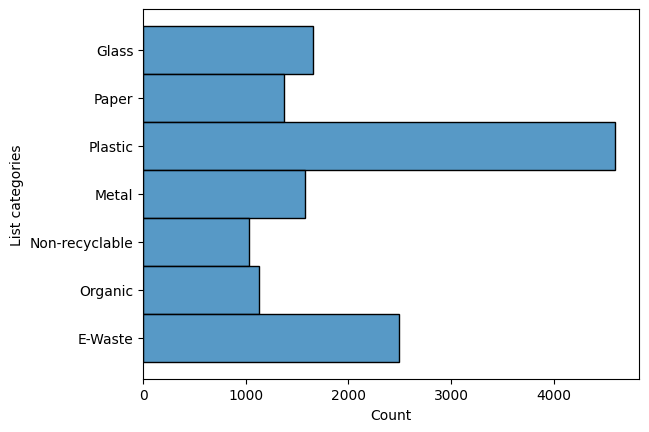

In [33]:
draw_class_distribution('../data/Final_Dataset/final_annotations_coco_V6.json')

In [35]:
build_table_distribution('../data/Final_Dataset/final_annotations_coco_V6.json')

Plastic           4599
E-Waste           2492
Glass             1650
Metal             1576
Paper             1370
Organic           1132
Non-recyclable    1035
Name: List categories, dtype: int64

In [43]:
build_table_distribution_normalize('../data/Final_Dataset/final_annotations_coco_V6.json')

Plastic           33.196189
E-Waste           17.987585
Glass             11.909918
Metal             11.375776
Paper              9.888841
Organic            8.170925
Non-recyclable     7.470767
Name: List categories, dtype: float64

In [44]:
# Total number of images & annotations in final dataset

with open('../data/Final_Dataset/final_annotations_coco_V6.json') as f:
    json_file = json.load(f)

print("Total number of images: " + str(len(json_file['images'])))
print("Total number of annotations: " + str(len(json_file['annotations'])))

Total number of images: 9478
Total number of annotations: 13854
